In [1]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
import warnings
pio.renderers.default = "plotly_mimetype+notebook_connected"

## loading data and having first glance

In [2]:
warnings.filterwarnings("ignore")
deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df_death = pd.read_csv(deaths_url)
df_death.drop(['Province/State', 'Lat', 'Long'], axis=1, inplace=True)#drop useless columns
df_death_cw=df_death.groupby(['Country/Region'], as_index=False).sum()#country wise data
df_death_cw.head()

,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21,6/17/21
0,Afghanistan,0,0,0,0,0,0,0,0,0,...,3251,3305,3356,3412,3449,3527,3612,3683,3683,3842
1,Albania,0,0,0,0,0,0,0,0,0,...,2452,2452,2452,2453,2453,2453,2453,2454,2454,2454
2,Algeria,0,0,0,0,0,0,0,0,0,...,3537,3544,3552,3560,3565,3571,3579,3588,3598,3605
3,Andorra,0,0,0,0,0,0,0,0,0,...,127,127,127,127,127,127,127,127,127,127
4,Angola,0,0,0,0,0,0,0,0,0,...,803,811,815,819,825,831,836,842,847,851


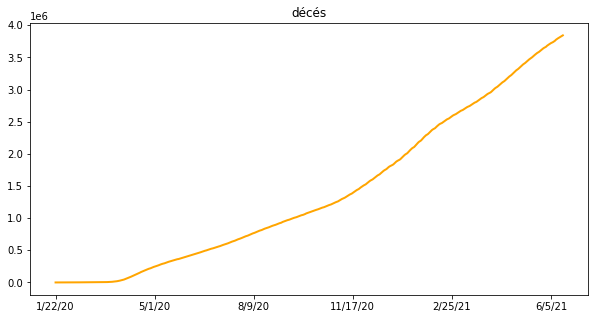

In [4]:
%matplotlib inline
worldwide_deaths=df_death.drop('Country/Region', axis=1).apply(np.sum)
worldwide_deaths.plot(figsize=(10,5), linewidth=2, fontsize=10,color='orange',title='décés')
plt.show()

## country wise charts

In [5]:
#population dataset
df_pop = pd.read_csv('C:/Users/eloma/Desktop/prj/covid-19/population.csv')
df_pop.replace(('United States', 'Russian Federation'), ('US', 'Russia'), inplace=True)
#changing the population dtype (year 2019) to numeric
df_pop=df_pop[pd.to_numeric(df_pop['2019 [YR2019]'], errors='coerce').notnull()]
df_pop=df_pop.astype({'2019 [YR2019]' : 'int64'})

In [6]:
#rename country columns to country 
df_pop.rename(columns={'Country Name':'Country','2019 [YR2019]':'population'},inplace=True)
df_death.rename(columns={'Country/Region':'Country'},inplace=True)
#lowering the country letters 
df_death.Country = df_death.Country.str.lower()
df_pop.Country = df_pop.Country.str.lower()
#merging datasets
population=df_pop.loc[:, ['Country', 'population']]
deaths_full=pd.merge(df_death, population, 'inner', on='Country')
# extreme countries
df_deaths_sum = deaths_full.sort_values(by=df_death.columns[-1], ascending=False)[0 : 10] #10 countries with most deaths
df_deaths_sum.set_index('Country', inplace=True)

In [7]:
countries=df_deaths_sum.index
cumulative = df_deaths_sum.iloc[:,-2]
population=df_deaths_sum.population
fig = go.Figure(data=[
    go.Bar(name='deaths', x=countries, y=cumulative),
    go.Bar(name='population', x=countries, y=population )
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type='log')

fig.update_layout(title="most influenced countries and<br> their populations",
                title_x=0.5,
                  yaxis_title="deaths-population")
fig.show()

In [8]:
countries = df_deaths_sum.index
cumulative = df_deaths_sum.iloc[:,-2]
population = df_deaths_sum.population
fig = go.Figure(data=[
    go.Bar(name='Normalized', x=countries, y=cumulative/population)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(type='log')

fig.update_layout(title="deaths normalised by population",
                title_x=0.5,
                  yaxis_title="normalised deaths")
fig.show()

In [9]:
df = df_deaths_sum.drop('population', axis=1)
df = df.transpose()
df.tail()

Country,us,brazil,india,mexico,peru,united kingdom,italy,russia,france,colombia
6/12/21,599665,486272,370384,230097,188100,127896,126976,123961,109503,95192
6/13/21,599776,487401,374305,230150,188708,127904,127002,124314,109509,95778
6/14/21,599946,488228,377031,230187,188708,127907,127038,124681,109572,96366
6/15/21,600285,490696,379573,230428,189261,127917,127101,125055,109645,96965
6/16/21,600653,493693,381903,230624,189261,127926,127153,125443,109685,97560


In [10]:
df = df_deaths_sum.drop('population', axis=1)
data = df.reset_index().melt(id_vars='Country', var_name='date')
data.head()

,Country,date,value
0,us,1/22/20,0
1,brazil,1/22/20,0
2,india,1/22/20,0
3,mexico,1/22/20,0
4,peru,1/22/20,0


In [11]:
data.loc[(data.value < 1), 'value'] = None
data.head()

,Country,date,value
0,us,1/22/20,NaN
1,brazil,1/22/20,NaN
2,india,1/22/20,NaN
3,mexico,1/22/20,NaN
4,peru,1/22/20,NaN


In [12]:
# Pivot data to wide & index by date
df = data.pivot(index='date', columns='Country', values='value')
df.tail()

Country,brazil,colombia,france,india,italy,mexico,peru,russia,united kingdom,us
date,,,,,,,,,,
9/5/20,126203.0,21156.0,30553.0,70626.0,35534.0,67326.0,75540.0,17707.0,41549.0,188672.0
9/6/20,126650.0,21412.0,30555.0,71642.0,35541.0,67558.0,75901.0,17768.0,41551.0,189144.0
9/7/20,126960.0,21615.0,30578.0,72775.0,35553.0,67781.0,76255.0,17818.0,41554.0,189439.0
9/8/20,127464.0,21817.0,30616.0,73890.0,35563.0,68484.0,76586.0,17939.0,41586.0,189894.0
9/9/20,128539.0,22053.0,30643.0,75062.0,35577.0,69049.0,76906.0,18080.0,41594.0,191055.0


In [13]:
# Set index as DateTimeIndex
datetime_index = pd.DatetimeIndex(df.index)
df.set_index(datetime_index, inplace=True)
df.head()

Country,brazil,colombia,france,india,italy,mexico,peru,russia,united kingdom,us
date,,,,,,,,,,
2021-01-01,195411.0,43495.0,64399.0,148994.0,74621.0,126507.0,93231.0,56798.0,74125.0,354360.0
2021-01-10,203100.0,46114.0,67380.0,151160.0,78755.0,133706.0,94976.0,60963.0,81431.0,381464.0
2021-01-11,203580.0,46451.0,67690.0,151327.0,79203.0,134368.0,95233.0,61389.0,81960.0,383570.0
2021-01-12,204690.0,46782.0,68431.0,151529.0,79819.0,135682.0,95483.0,61908.0,83203.0,388045.0
2021-01-13,205964.0,47124.0,68660.0,151727.0,80326.0,136917.0,95728.0,62463.0,84767.0,392057.0


Text(0.5, 1.0, 'deaths numbers evolution')

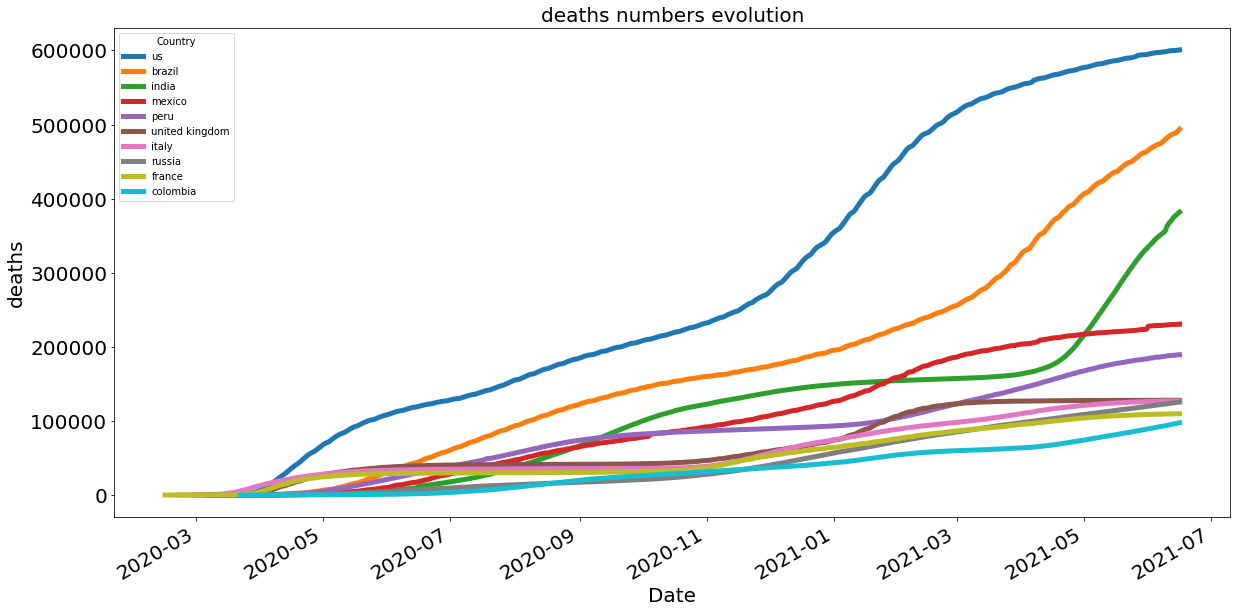

In [14]:
# Plot time series of several countries of interest
countries = df_deaths_sum.index
df[countries].plot(figsize=(20, 10), linewidth=5, fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('deaths', fontsize=20)
plt.title('deaths numbers evolution', fontsize=20)

# time series analysis

In [15]:
# transform data to daily deaths instead of accumulations 
df_death.drop('Country', axis=1, inplace=True)
daily_deaths = df_death.copy()
cf_columns = list(df_death.columns)
cf_columns.reverse()
indices = [i for i in range(len(cf_columns)-1, -1, -1)]
for i,col in zip(indices, cf_columns[: -1]):
    daily_deaths[col] -= df_death.iloc[:, i-1]
daily_deaths.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,6/7/21,6/8/21,6/9/21,6/10/21,6/11/21,6/12/21,6/13/21,6/14/21,6/15/21,6/16/21
0,0,0,0,0,0,0,0,0,0,0,...,42,64,54,51,56,37,78,85,71,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,9,10,7,8,8,5,6,8,9,10
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,3,3,8,4,4,6,6,5,6,5


In [16]:
#create a time series of worldwide daily deaths  
df=pd.DataFrame(daily_deaths.apply(np.sum),columns=['deathIncrease'])
df.index= pd.to_datetime(df.index) 
df.head()

,deathIncrease
2020-01-22,17
2020-01-23,1
2020-01-24,8
2020-01-25,16
2020-01-26,14


Text(0.5, 1.0, 'worldwide daily deaths')

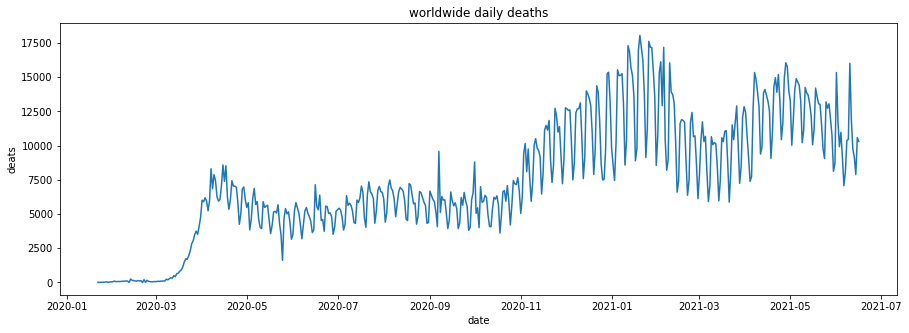

In [17]:
plt.figure(figsize=(15, 5))
plt.plot(df)
plt.xlabel('date')
plt.ylabel('deats')
plt.title('worldwide daily deaths')

it is obvious that the serie is not stationary , but let's check that with more 'statistical' way

In [18]:
df_train=df.loc['2020-05-01':'2021-06-01']
df_test=df.loc['2021-06-01':]

### stationarity

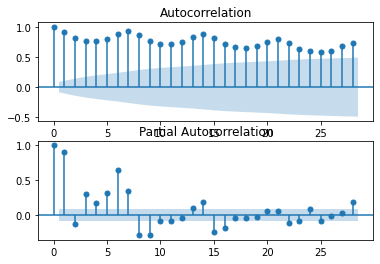

In [19]:
fig,axs=plt.subplots(2,1)
plot_acf(df.deathIncrease.values,ax=axs[0])
plot_pacf(df.deathIncrease.values,ax=axs[1])
plt.show()

we can see that the lags are autocorrelated and have a pattern , and they don't get to zero quickly

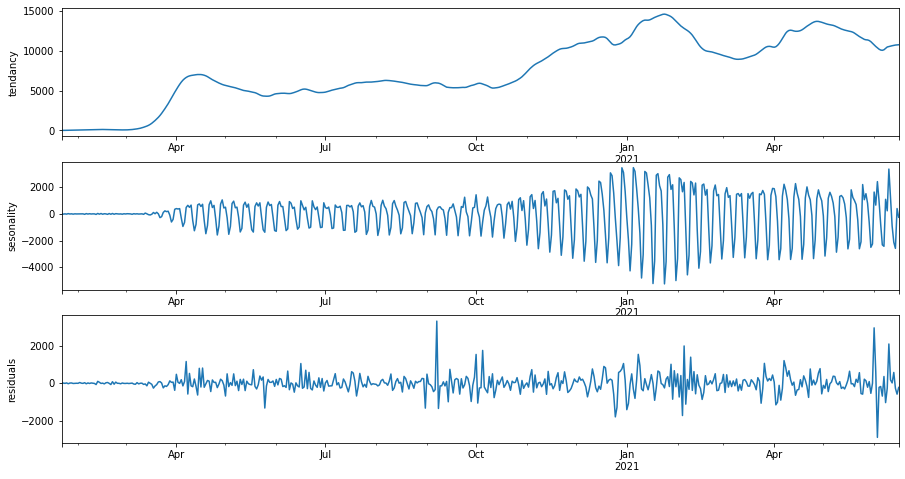

In [20]:
res=STL(df.deathIncrease).fit()
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "tendancy")
res.seasonal.plot(ax=ax2,ylabel = "sesonality")
res.resid.plot(ax=ax3,ylabel = "residuals")
plt.show()

the tendancy doesn't have a constant a slope , so maybe we will have to do more than one differenciation

In [21]:
def kpss_test(timeseries, string):
    print (f"KPSS results for {string}")
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output["critical value (%s)"%key] = value
    print (kpss_output)
kpss_test(df.deathIncrease, "deaths time series")

KPSS results for deaths time series
Test Statistic            3.253919
p-value                   0.010000
Lags Used                12.000000
critical value (10%)      0.347000
critical value (5%)       0.463000
critical value (2.5%)     0.574000
critical value (1%)       0.739000
dtype: float64


the p-value<0.05 we reject the null hypothesis , hence the time serie is non-stationary

### choice of d (differenciation order)

In [22]:
df1 = df.diff().dropna()
df2 = df1.diff().dropna()

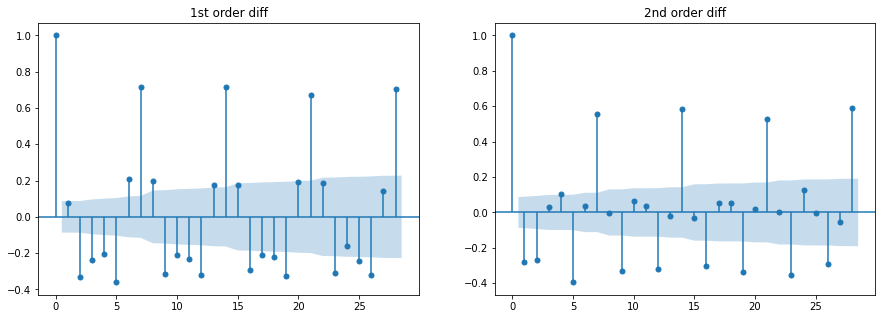

In [23]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
plot_acf(df1.deathIncrease.values,ax=axs[0])
axs[0].set_title('1st order diff')
plot_acf(df2.deathIncrease.values,ax=axs[1])
axs[1].set_title('2nd order diff')
plt.show()

in the 2nd differenciation, the lags get to negative values very quickly(since 2nd lag)(a sharp cut-off), so it might be overdifferenciated , let's check :

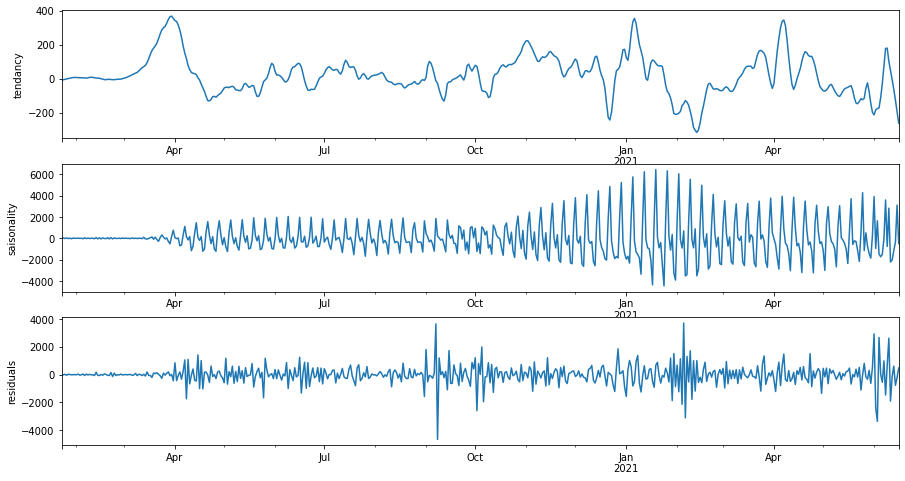

In [24]:
res=STL(df1.deathIncrease).fit()
fig, axs = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=axs[0],ylabel = "tendancy")
res.seasonal.plot(ax=axs[1],ylabel = "saisonality")
res.resid.plot(ax=axs[2],ylabel = "residuals")
plt.show()

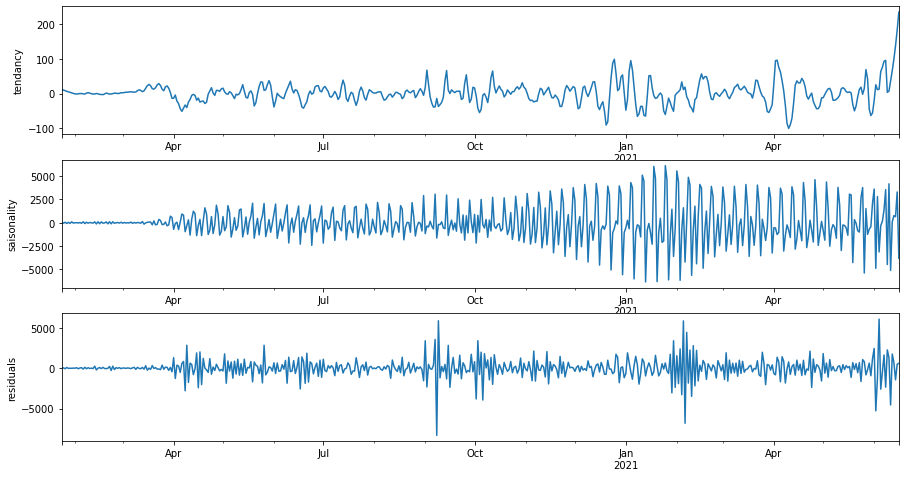

In [25]:
res=STL(df2.deathIncrease).fit()
fig, axs = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=axs[0],ylabel = "tendancy")
res.seasonal.plot(ax=axs[1],ylabel = "saisonality")
res.resid.plot(ax=axs[2],ylabel = "residuals")
plt.show()

from the serie differenciations we can see that tendancy is eliminated since 1st order ,but there still be some sort of seasonality in both cases , maybe a seasonal differenciation can solve this. 

In [26]:
kpss_test(df1.deathIncrease, '1st order diff')
kpss_test(df2.deathIncrease, '2nd order diff')

KPSS results for 1st order diff
Test Statistic             0.392384
p-value                    0.080438
Lags Used                272.000000
critical value (10%)       0.347000
critical value (5%)        0.463000
critical value (2.5%)      0.574000
critical value (1%)        0.739000
dtype: float64
KPSS results for 2nd order diff
Test Statistic             0.087453
p-value                    0.100000
Lags Used                101.000000
critical value (10%)       0.347000
critical value (5%)        0.463000
critical value (2.5%)      0.574000
critical value (1%)        0.739000
dtype: float64


the p-value is >0.05 in both cases ,wich is good :according to this test both are statitionary. but since the acf plots showed that 2nd order seems overdiffereciated(and it didn't eliminate seasonality) we can choose the 1st order (d=1) with a seasonal differenciation(D=1): d=1,D=1 

### choice of p

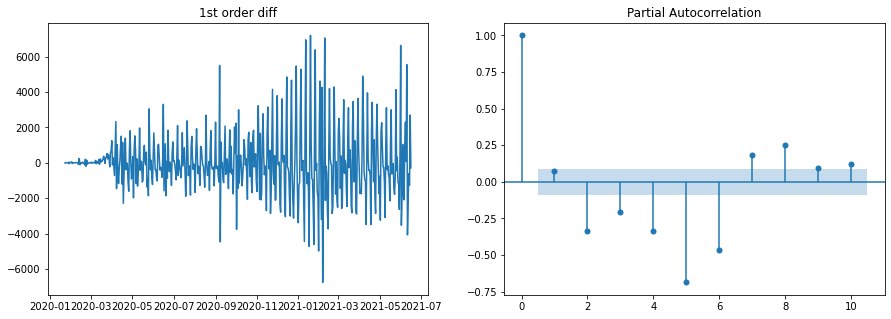

In [27]:
fig,axs=plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(df1.deathIncrease)
axs[0].set_title('1st order diff')
plot_pacf(df1.deathIncrease,lags=10,ax=axs[1])
plt.show()

only one lag is significant but this 1st lag has a large positive value , so we add a p term (the priority goes to AR terms here)
we take p=2

### choice of q

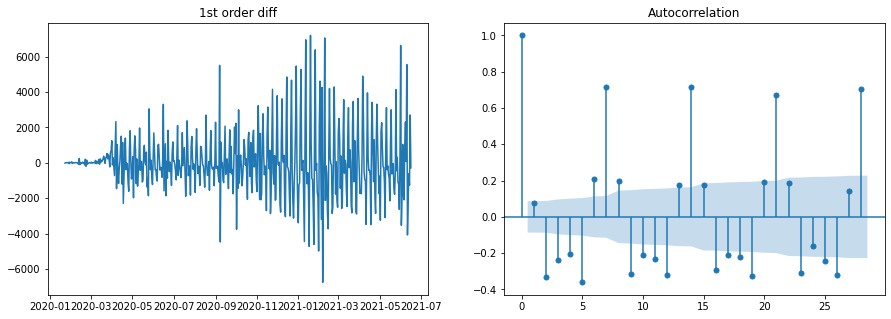

In [28]:
fig,axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(df1.deathIncrease)
axs[0].set_title('1st order diff')
plot_acf(df1.deathIncrease, ax=axs[1])
plt.show()

the same remark again,since 1st lag has a large positive value AR(p) terms are given priority, we take q=1,Q=0

## the model

In [29]:
model=SARIMAX(endog=df.deathIncrease, order=(2, 1, 1), seasonal_order=(0, 1, 0, 7))
res = model.fit()
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      deathIncrease   No. Observations:                  512
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 7)   Log Likelihood               -4230.619
Date:                            Fri, 18 Jun 2021   AIC                           8469.238
Time:                                    03:25:16   BIC                           8486.128
Sample:                                01-22-2020   HQIC                          8475.863
                                     - 06-16-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1803      0.045      3.962      0.000       0.091       0.269
ar.L2          0.1185      0.049   

all p-values are <0.05 :we can accept the model

## automatic research of the model

In [30]:
auto_model = pm.auto_arima(df.deathIncrease, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, D=1, seasonal=True,
                         d=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=False)
print(auto_model.summary())

 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8668.387, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=8462.182, Time=0.30 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=8463.799, Time=0.76 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=8539.090, Time=0.09 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=8463.789, Time=0.42 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=8460.681, Time=1.70 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=8509.084, Time=0.18 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=8465.726, Time=0.86 sec
 ARIMA(0,1,0)(2,1,2)[7]             : AIC=8461.356, Time=1.64 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=8474.122, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=8336.084, Time=0.40 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=8337.310, Time=0.81 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=8381.708, Time=0.40 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=8337.132, Time=0.64 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=2.11 sec
 ARIMA(0,1,1)(2

we had a better model(lower AIC) than the one we set manually, and all p-values are<0.05. GREAT!!

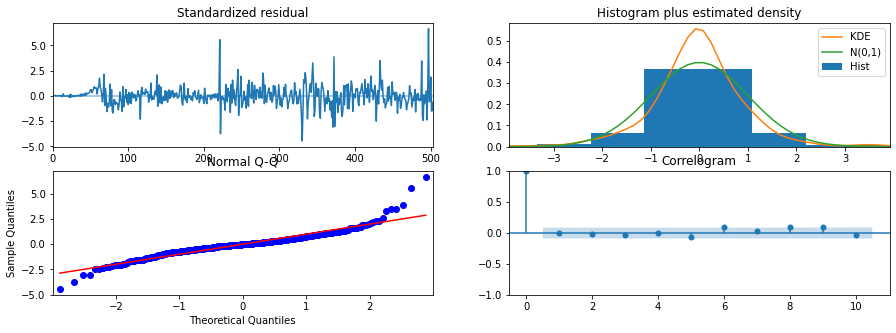

In [31]:
auto_model.plot_diagnostics(figsize=(15,5))
plt.show()

(top right)the density of residuals shows a normal distribution with a mean of 0 .
(top left)the residuals fluctuate around a mean of 0 and have a uniform variance.
(bottum right)the residuals are not autocorrelated.
(bottum left)points are generally aligned with the red line , so there isn't high skewness 

### prediction

In [32]:
predictions=pd.DataFrame(auto_model.predict(n_periods=len(df_test)),columns=['test'],index=df_test.index)

In [33]:
predictions

,test
2021-06-01,12073.797881
2021-06-02,10895.895164
2021-06-03,8995.427156
2021-06-04,7479.488404
2021-06-05,7277.102801
2021-06-06,10872.834464
2021-06-07,10024.699964
2021-06-08,11826.635377
2021-06-09,10257.606361
2021-06-10,8694.909126


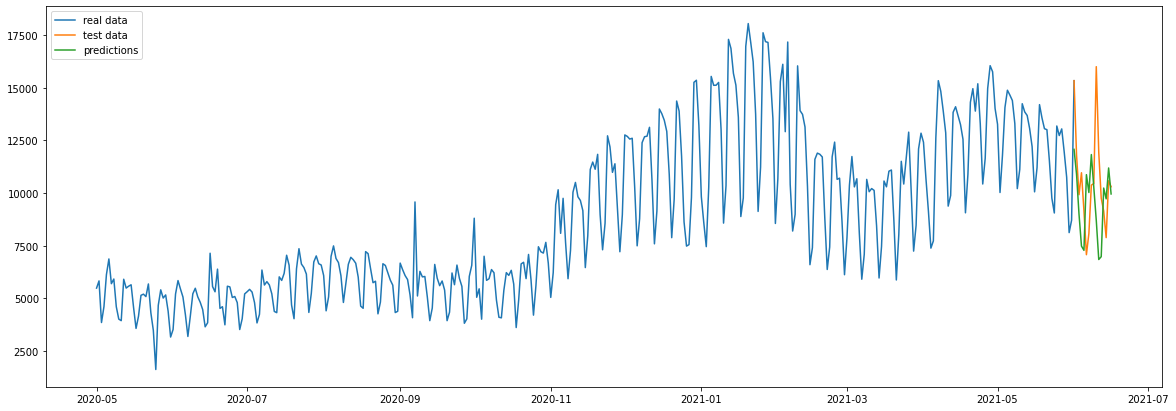

In [34]:
plt.figure(figsize=(20,7))
plt.plot(df_train.deathIncrease, label="real data")
plt.plot(df_test.deathIncrease, label="test data")
plt.plot(predictions, label="predictions")
plt.legend(loc='upper left')
plt.show()

In [35]:
predictions=pd.DataFrame(auto_model.predict(n_periods=35),columns=['prediction'],index=pd.date_range(start='6/1/2021', periods=35))

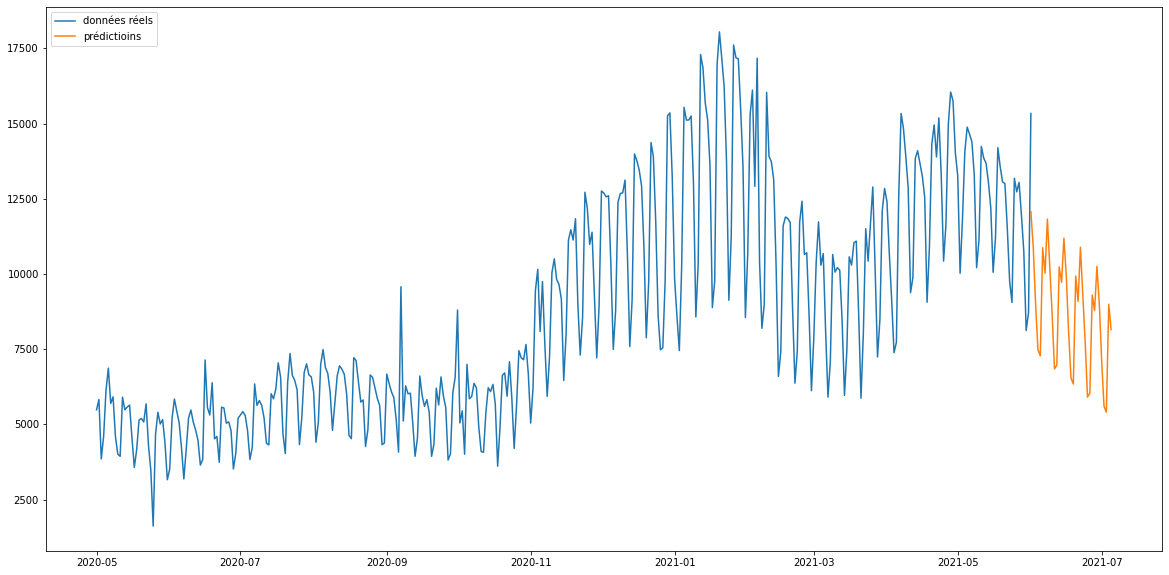

In [36]:
plt.figure(figsize=(20,10))
plt.plot(df_train.deathIncrease, label="données réels")
plt.plot(predictions, label='prédictioins')
plt.legend(loc='upper left')
plt.show()

In [37]:
predictions

,prediction
2021-06-01,12073.797881
2021-06-02,10895.895164
2021-06-03,8995.427156
2021-06-04,7479.488404
2021-06-05,7277.102801
2021-06-06,10872.834464
2021-06-07,10024.699964
2021-06-08,11826.635377
2021-06-09,10257.606361
2021-06-10,8694.909126
